In [22]:
!pip install duckdb

In [34]:
%matplotlib inline

# adding project dirs to path so code may be referenced from the notebook
import sys
sys.path.insert(0, '..')

In [35]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import config
import utils

In [45]:
# load huc10
%time
basins_gdf = utils.parquet_to_gdf(config.HUC10_PARQUET_FILEPATH)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [37]:
basins_gdf

,objectid,huc10,name,geometry
0,1.0,1016000606,Foster Creek,"POLYGON ((-97.77012 44.94218, -97.76927 44.941..."
1,2.0,0709000208,Badfish Creek,"POLYGON ((-89.42163 42.98052, -89.42130 42.980..."
2,3.0,1806000901,San Antonio Creek,"POLYGON ((-120.47395 34.84828, -120.47386 34.8..."
3,4.0,1805000409,San Mateo Creek-Frontal San Francisco Bay Estu...,"POLYGON ((-122.42777 37.79177, -122.42757 37.7..."
4,5.0,1705010807,Lower Cow Creek,"POLYGON ((-117.26970 43.23085, -117.26954 43.2..."
...,...,...,...,...
16159,19276.0,1805000208,San Pablo Bay,"POLYGON ((-122.28155 38.27869, -122.28162 38.2..."
16160,19277.0,1805000209,Corte Madera Creek-Frontal San Fransisco Bay E...,"MULTIPOLYGON (((-122.59580 38.02898, -122.5957..."
16161,19278.0,1805000210,San Francisco Bay,"POLYGON ((-122.46634 37.99745, -122.46606 37.9..."
16162,19345.0,0313001404,Alligator Harbor,"POLYGON ((-84.33103 29.95428, -84.32967 29.954..."


<AxesSubplot: >

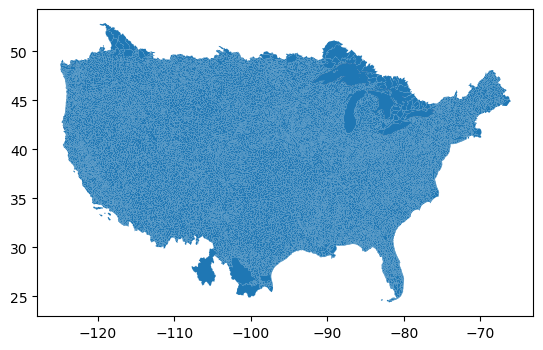

In [38]:
basins_gdf.plot()

In [39]:
# Query some forcast data from parquet files
import importlib
import queries
importlib.reload(queries)

<module 'queries' from '/home/matt/repos/hydro-evaluation/src/evaluation/queries/queries.py'>

In [40]:
# query = queries.calculate_catchment_metrics(
#     config.MEDIUM_RANGE_FORCING_PARQUET,
#     config.FORCING_ANALYSIS_ASSIM_PARQUET,
#     group_by=["catchment_id"],
#     order_by=["observed_average"],
#     filters=[
#         {
#             "column": "reference_time",
#             "operator": "=",
#             "value": "2023-01-03 12:00:00"
#         },
#         {
#             "column": "catchment_id",
#             "operator": "like",
#             "value": "18%"
#         }
#     ]
# )


query = queries.calculate_catchment_metrics(
    config.MEDIUM_RANGE_FORCING_PARQUET,
    config.FORCING_ANALYSIS_ASSIM_PARQUET,
    group_by=["catchment_id"],
    order_by=["observed_average"],
    filters=[
        {
            "column": "catchment_id",
            "operator": "like",
            "value": "18%"
        },
        {
            "column": "reference_time",
            "operator": "=",
            "value": "2023-01-03 12:00:00"
        },
    ]
)
print(query)
df = duckdb.query(query).to_df()
df

{'column': 'catchment_id', 'operator': 'like', 'value': '18%'}
{'column': 'reference_time', 'operator': '=', 'value': '2023-01-03 12:00:00'}

        WITH joined as (
            SELECT 
                nd.reference_time,
                nd.value_time,
                nd.catchment_id,   
                nd.value as forecast_value, 
                nd.configuration,  
                nd.measurement_unit,     
                nd.variable_name,
                ud.value as observed_value,
                nd.value_time - nd.reference_time as lead_time
            FROM '/home/matt/cache/parquet/forcing_medium_range/*.parquet' nd 
            JOIN '/home/matt/cache/parquet/forcing_analysis_assim/*.parquet' ud 
                on ud.catchment_id = nd.catchment_id
                and nd.value_time = ud.value_time 
                and nd.measurement_unit = ud.measurement_unit
                and nd.variable_name = ud.variable_name
        )
        SELECT 
            catchment_id,
            r

,catchment_id,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,max_forecast_delta,bias
0,1810010052,NaN,0.000000e+00,NaN,NaN,240,240,1.464027e-06,0.000000,1.833674e-10,0.000000e+00,0.000196,-1.464027e-06
1,1810020401,NaN,0.000000e+00,NaN,NaN,240,240,5.028597e-07,0.000000,4.097652e-11,0.000000e+00,0.000098,-5.028597e-07
2,1810020404,NaN,0.000000e+00,NaN,NaN,240,240,3.414193e-07,0.000000,7.759476e-12,0.000000e+00,0.000030,-3.414193e-07
3,1810020402,NaN,0.000000e+00,NaN,NaN,240,240,1.118950e-06,0.000000,8.037943e-11,0.000000e+00,0.000111,-1.118950e-06
4,1810020407,NaN,0.000000e+00,NaN,NaN,240,240,5.823605e-08,0.000000,4.862850e-13,0.000000e+00,0.000011,-5.823605e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,1802000403,0.000237,9.825708e-08,0.376065,0.141425,240,240,4.064164e-04,0.000433,2.707571e-07,2.521287e-07,-0.000482,2.704694e-05
1005,1802000404,0.000322,7.117938e-08,0.237082,0.056208,240,240,4.389834e-04,0.000451,3.289028e-07,2.740593e-07,-0.000296,1.218821e-05
1006,1802000503,0.000313,1.484975e-07,0.387681,0.150296,240,240,5.236997e-04,0.000476,4.367572e-07,3.359309e-07,-0.001162,-4.814564e-05
1007,1802000504,0.000313,9.550830e-08,0.272606,0.074314,240,240,4.308441e-04,0.000483,3.126793e-07,3.925656e-07,-0.002267,5.246139e-05


<AxesSubplot: >

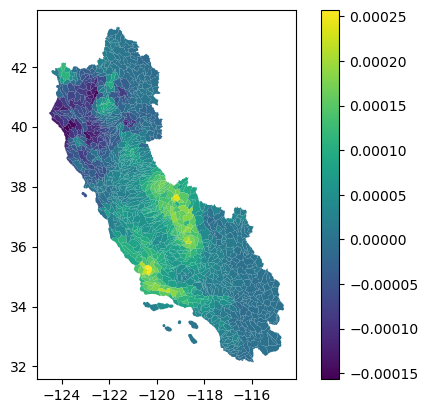

In [41]:
# Join query to basins
gdf_map = basins_gdf.merge(df, left_on="huc10", right_on="catchment_id")

# Filter to CA
# gdf_map = gdf_map.loc[gdf_map["catchment_id"].str.startswith("18")]

gdf_map.plot("bias", legend=True)

In [42]:
query = queries.get_joined_catchment_timeseries(
    config.MEDIUM_RANGE_FORCING_PARQUET,
    config.FORCING_ANALYSIS_ASSIM_PARQUET,
    filters=[
        {
            "column": "reference_time",
            "operator": "=",
            "value": "2023-01-03 12:00:00"
        },
        {
            "column": "catchment_id",
            "operator": "=",
            "value": "1802000502"
        },
    ]
)

df = duckdb.query(query).to_df()
df

{'column': 'reference_time', 'operator': '=', 'value': '2023-01-03 12:00:00'}
{'column': 'catchment_id', 'operator': '=', 'value': '1802000502'}


,reference_time,value_time,catchment_id,forecast_value,configuration,measurement_unit,variable_name,observed_value,lead_time
0,2023-01-03 12:00:00,2023-01-03 13:00:00,1802000502,0.000016,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 01:00:00
1,2023-01-03 12:00:00,2023-01-03 14:00:00,1802000502,0.000018,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 02:00:00
2,2023-01-03 12:00:00,2023-01-03 15:00:00,1802000502,0.000023,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 03:00:00
3,2023-01-03 12:00:00,2023-01-03 16:00:00,1802000502,0.000018,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 04:00:00
4,2023-01-03 12:00:00,2023-01-03 17:00:00,1802000502,0.000019,forcing_medium_range,mm s^-1,precipitation_flux,0.000000,0 days 05:00:00
...,...,...,...,...,...,...,...,...,...
235,2023-01-03 12:00:00,2023-01-13 08:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000096,9 days 20:00:00
236,2023-01-03 12:00:00,2023-01-13 09:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000636,9 days 21:00:00
237,2023-01-03 12:00:00,2023-01-13 10:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000188,9 days 22:00:00
238,2023-01-03 12:00:00,2023-01-13 11:00:00,1802000502,0.000000,forcing_medium_range,mm s^-1,precipitation_flux,0.000308,9 days 23:00:00


<AxesSubplot: xlabel='value_time'>

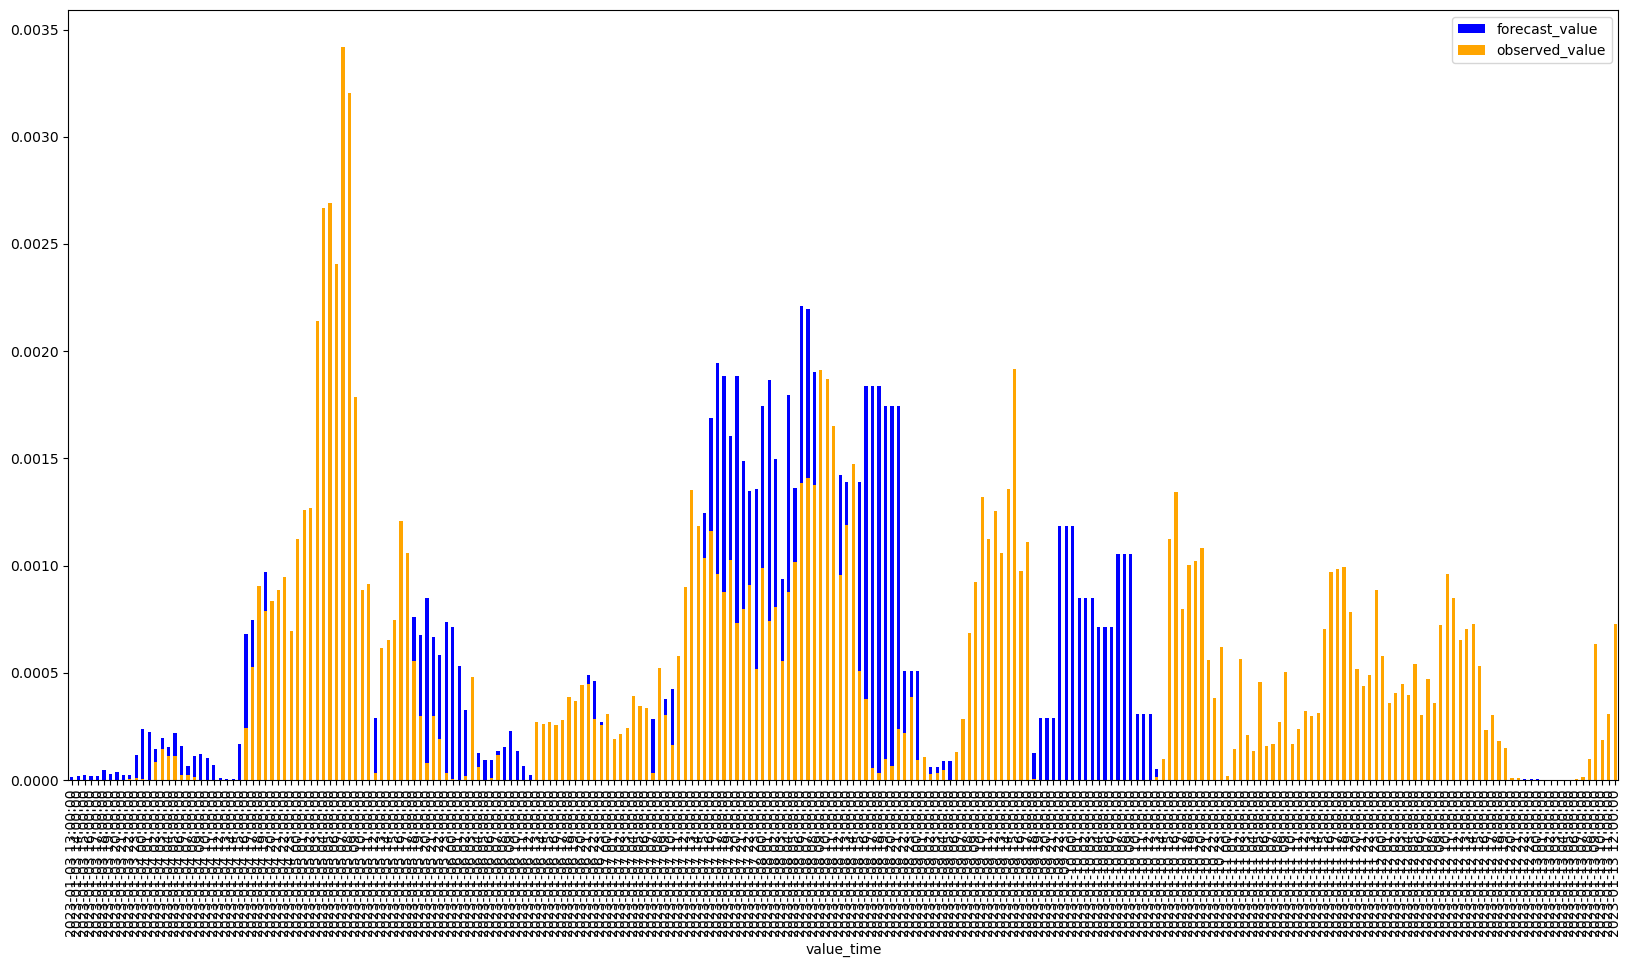

In [43]:
ax = plt.gca()
df.plot.bar(x= 'value_time', y="forecast_value", ax=ax, figsize=(20,10), color="blue", stacked=True)
df.plot.bar(x= 'value_time', y="observed_value", ax=ax, figsize=(20,10), color="orange", stacked=True)